# California House Prices Predictor
Based on the hands-on exercise in Chapter 2 of `Hands On Machine Learning with Scikit-learn, Keras and Tensorflow` by `Aurelian Geron`

In [2]:
import os, random
import tarfile
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

%matplotlib inline

SEED = 41
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# fetch the data
SOURCE_URL_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = SOURCE_URL_ROOT + "/datasets/housing/housing.tgz"
TARGET_PATH = os.path.join(".", "data", "housing")
TARGET_FILE = os.path.join(TARGET_PATH, "housing.tgz")

def fetch_housing_data(force : bool = False) -> None:
    if force or (not os.path.exists(TARGET_PATH)):
        # download & extract if forced or target does not already exist
        os.makedirs(TARGET_PATH, exist_ok=True)
        urllib.request.urlretrieve(HOUSING_URL, TARGET_FILE)
        with tarfile.open(TARGET_FILE) as tf:
            tf.extractall(path=TARGET_PATH)


fetch_housing_data()

In [4]:
HOUSING_DATASET = os.path.join(TARGET_PATH, "housing.csv")
assert os.path.exists(HOUSING_DATASET)

In [5]:
# open housing.csv in pandas
housing = pd.read_csv(HOUSING_DATASET)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


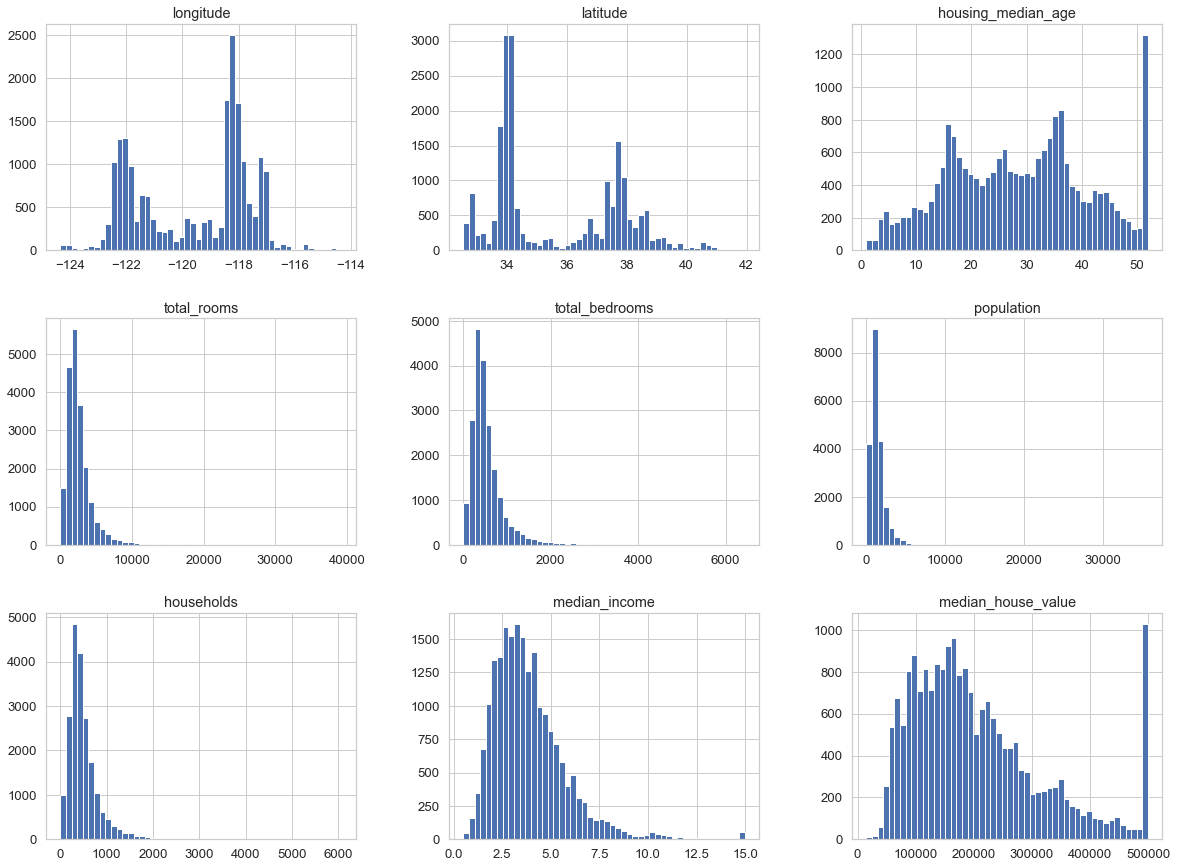

In [9]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:>

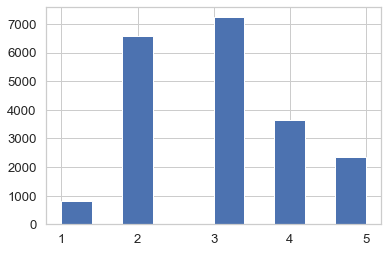

In [10]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()

In [11]:
# set aside a test set 
from sklearn.model_selection import StratifiedShuffleSplit

def split_train_test(data, test_ratio):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    for train_indices, test_indices in sss.split(housing, housing['income_cat']):
        strat_test_set = housing.loc[train_indices]
        strat_test_set = housing.loc[test_indices]
    return strat_test_set, strat_test_set

test_set, test_set = split_train_test(housing, 0.2)
print(f"test_set.shape: {test_set.shape} - test_set.shape: {test_set.shape}")

train_set.shape: (16512, 11) - test_set.shape: (4128, 11)


In [12]:
housing['income_cat'].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [13]:
test_set['income_cat'].value_counts() / len(test_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [14]:
# drop the income_cat column
for set_ in (test_set, test_set):
    set_.drop('income_cat', axis=1, inplace=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


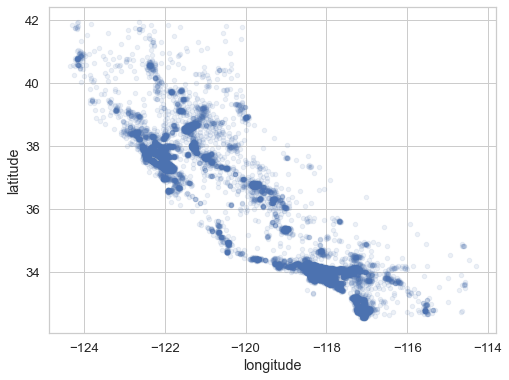

In [15]:
test_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, figsize=(8,6));

Now let’s look at the housing prices (Figure 2-13). The radius of each circle represents the district’s population (option `s`), and the color represents the price (option `c`). We will use a predefined color map (option `cmap`) called `jet`, which ranges from blue (low values) to red (high prices)

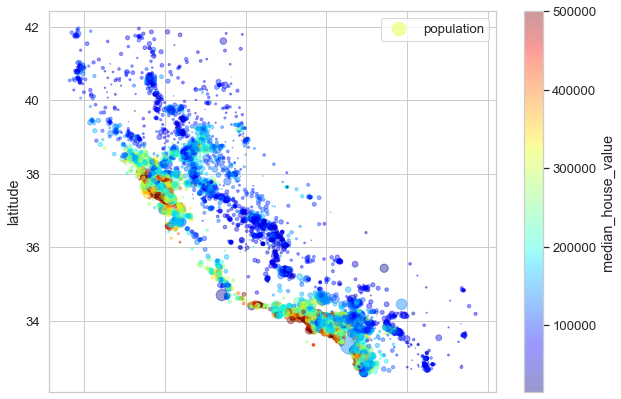

In [16]:
test_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
               s=test_set["population"]/100, label="population", figsize=(10,7), 
               c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show();

Now let’s look at how much each attribute correlates with the median house value

In [17]:
corr_matrix = test_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687668
total_rooms           0.131987
housing_median_age    0.111686
households            0.063285
total_bedrooms        0.046671
population           -0.024677
longitude            -0.049897
latitude             -0.141620
Name: median_house_value, dtype: float64

The above shows that `median_income` has the strongest positive co-relation with `median_house_value`, implying that `median_house_values` generally *increase* with increasing `meadian_income`. Also, there is a slight -ve co-relation with `latitude` implying that in general if we go north, the house prices decrease.

Another way to check co-realationship is to use `pandas'` `scatter_matrix()` funtion - it will create a scatter plot between all numeric attributes. Since there are 8, you'll get a `(8+1) x (8+1)` matrix. So we'll use just a few selected attributes.

In [18]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 11632 to 6464
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16348 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


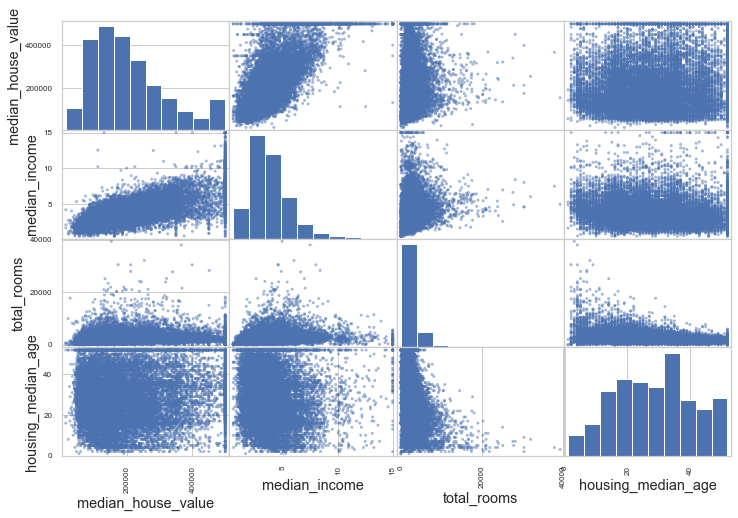

In [19]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(test_set[attributes], figsize=(12, 8)); # NOTE: the ; prevents a log of diagnostic messages

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


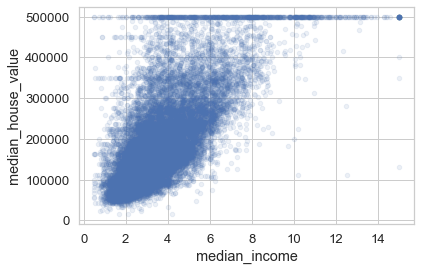

In [23]:
test_set.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1);
plt.show();

In [24]:
test_set["rooms_per_household"] = test_set["total_rooms"]/test_set["households"]
test_set["bedrooms_per_room"] = test_set["total_bedrooms"]/test_set["total_rooms"]
test_set["population_per_household"] = test_set["population"]/test_set["households"]
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
11632,-118.03,33.82,20.0,2662.0,464.0,1275.0,472.0,6.0162,318500.0,<1H OCEAN,5.639831,0.174305,2.701271
10673,-117.85,33.62,13.0,5192.0,658.0,1865.0,662.0,15.0001,500001.0,<1H OCEAN,7.842900,0.126733,2.817221
12532,-121.51,38.57,36.0,613.0,166.0,425.0,147.0,2.2031,93800.0,INLAND,4.170068,0.270799,2.891156
2600,-123.63,41.11,19.0,1797.0,384.0,1033.0,327.0,1.4911,59200.0,<1H OCEAN,5.495413,0.213689,3.159021
12074,-117.60,33.87,18.0,6450.0,1165.0,3716.0,1113.0,4.2721,150300.0,INLAND,5.795148,0.180620,3.338724


In [26]:
corr_matrix = test_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687668
rooms_per_household         0.155908
total_rooms                 0.131987
housing_median_age          0.111686
households                  0.063285
total_bedrooms              0.046671
population                 -0.024677
population_per_household   -0.032129
longitude                  -0.049897
latitude                   -0.141620
bedrooms_per_room          -0.256628
Name: median_house_value, dtype: float64

In [27]:
test_set["rooms_per_household"] = test_set["total_rooms"]/test_set["households"]
test_set["bedrooms_per_room"] = test_set["total_bedrooms"]/test_set["total_rooms"]
test_set["population_per_household"] = test_set["population"]/test_set["households"]
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
15159,-117.05,32.96,18.0,3593.0,661.0,1992.0,626.0,4.8295,165800.0,<1H OCEAN,5.739617,0.183969,3.182109
6733,-118.09,34.12,45.0,2966.0,415.0,1231.0,409.0,7.8347,500001.0,<1H OCEAN,7.251834,0.139919,3.009780
6422,-118.00,34.13,24.0,2584.0,520.0,1869.0,503.0,3.2841,167000.0,INLAND,5.137177,0.201238,3.715706
317,-122.20,37.76,37.0,2680.0,736.0,1925.0,667.0,1.4097,84600.0,NEAR BAY,4.017991,0.274627,2.886057
5385,-118.41,34.03,24.0,3711.0,1192.0,1764.0,1147.0,3.1642,366700.0,<1H OCEAN,3.235397,0.321207,1.537925
